In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
import torch.nn as nn
from transformer_model import ELAN
from swinir_model import SwinIR
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../lib")))
from utils import get_split_datapaths, psnr, init_logging
from dataloader import PassiveMicrowaveDataset
import torch
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np
import cv2
from torchvision.transforms import ToTensor

from datetime import datetime

/home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
train_paths, val_paths, test_paths = get_split_datapaths()

2025-05-14 13:45:32,750 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2011/11 does not exist. Skipping...
2025-05-14 13:45:32,751 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2011/12 does not exist. Skipping...
2025-05-14 13:45:32,752 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2012/01 does not exist. Skipping...
2025-05-14 13:45:32,753 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2012/02 does not exist. Skipping...
2025-05-14 13:45:32,753 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2012/03 does not exist. Skipping...
2025-05-14 13:45:32,754 - root - INFO - Warning: Directory /lustre/storeB/p

In [4]:
print(len(train_paths))
print(len(val_paths))
print(len(test_paths))
print(len(train_paths)+len(val_paths)+ len(test_paths))

5477
365
364
6206


In [5]:
# Initialize test dataset with normalization
test_dataset = PassiveMicrowaveDataset(test_paths, transform=ToTensor(), normalize=True, use_bicubic=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [6]:
logger = init_logging()

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim

def plot_single_sample(model_pth, test_paths, test_dataset, sample_idx, device="cuda" if torch.cuda.is_available() else "cpu", denormalize = True):
    """
    Plot a single test sample's low-resolution input, high-resolution ground truth, 
    and model output along with the PSNR and MSE.
    """
    time = test_paths[sample_idx].split("_")[-1].replace(".nc","")
    dt = datetime.strptime(str(time), "%Y%m%d%H")
    dt.strftime("%Y-%m-%d %H:00")
    print(dt)



    if "ELAN" in model_pth.split("_")[1].split("/"):
        model = ELAN()
        model_name = "ELAN"
    elif "SwinIR" in model_pth.split("_")[1].split("/"):
        model = SwinIR( img_size=416,
                        in_chans=2,
                        upscale=1,
                        window_size=4, 
                        upsampler=None,  
                        img_range=1.0,
                        embed_dim=24,
                        num_heads=[4, 4, 4, 4]
                        )
        model_name = "SwinIR"

    model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))
    model.eval()  # Set the model to evaluation mode
    print("Model loaded... ")
    # Get a single test sample
    low_res, high_res = test_dataset[sample_idx]

    # Convert to batch format and move to device
    low_res_tensor = low_res.clone().detach().unsqueeze(0).to(device)
    high_res_tensor = high_res.clone().detach().unsqueeze(0).to(device)
    print(low_res_tensor.shape)
    # low_res_tensor = low_res_tensor[:, :, 80:240, 80:240]
    # high_res_tensor = high_res_tensor[:, :, 80:240, 80:240]
    print(low_res_tensor.shape)

    # Run model inference
    with torch.no_grad():
        output = model(low_res_tensor)

    # Move data back to CPU and convert to NumPy
    if denormalize:
        low_res = test_dataset.denormalize(low_res_tensor.squeeze(0)).cpu().numpy()
        high_res = test_dataset.denormalize(high_res_tensor.squeeze(0)).cpu().numpy()
        output = test_dataset.denormalize(output.squeeze(0)).cpu().numpy()
    else:
        low_res = low_res_tensor.squeeze(0).cpu().numpy()
        high_res = high_res_tensor.squeeze(0).cpu().numpy()
        output = output.squeeze(0).cpu().numpy()  

    
    # Mask to exclude regions where high_res is 0
    mask_v = high_res[0] > 0
    mask_h = high_res[1] > 0

    # Filtered tensors
    filtered_output_v = output[0][mask_v]
    filtered_high_res_v = high_res[0][mask_v]
    filtered_low_res_v = low_res[0][mask_v]

    filtered_output_h = output[1][mask_h]
    filtered_high_res_h = high_res[1][mask_h]
    filtered_low_res_h = low_res[1][mask_h]

    # PSNR computation
    psnr_value_v = psnr(torch.tensor(filtered_high_res_v), torch.tensor(filtered_output_v), pol="V").item()
    psnr_baseline_v = psnr(torch.tensor(filtered_high_res_v), torch.tensor(filtered_low_res_v), pol="V").item()

    psnr_value_h = psnr(torch.tensor(filtered_high_res_h), torch.tensor(filtered_output_h), pol="H").item()
    psnr_baseline_h = psnr(torch.tensor(filtered_high_res_h), torch.tensor(filtered_low_res_h), pol="H").item()

    # SSIM computation
    ssim_low_res_v = ssim(filtered_high_res_v, filtered_low_res_v, data_range=filtered_high_res_v.max() - filtered_high_res_v.min())
    ssim_low_res_h = ssim(filtered_high_res_h, filtered_low_res_h, data_range=filtered_high_res_h.max() - filtered_high_res_h.min())

    ssim_output_v = ssim(filtered_high_res_v, filtered_output_v, data_range=filtered_high_res_v.max() - filtered_high_res_v.min())
    ssim_output_h = ssim(filtered_high_res_h, filtered_output_h, data_range=filtered_high_res_h.max() - filtered_high_res_h.min())

    #find H-pol min max
    combined_filtered_h = np.concatenate([filtered_low_res_h, filtered_high_res_h])
    h_min = np.min(combined_filtered_h)
    h_max = np.max(combined_filtered_h)

    #find V-pol min max
    combined_filtered_v = np.concatenate([filtered_low_res_v, filtered_high_res_v])
    v_min = np.min(combined_filtered_v)
    v_max = np.max(combined_filtered_v)

### PLOTTING ###
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
 
    # V-pol comparison
    im1 = axs[0, 0].imshow(low_res[0], cmap='turbo', vmin=v_min, vmax=v_max)
    axs[0, 0].axis('off')
    axs[0, 0].set_title("Low-Res SSMI 37 GHz (Input)")
    axs[0, 0].text(0.7, 0.9, f"PSNR: {psnr_baseline_v:.3f}\nSSIM: {ssim_low_res_v:.3f}", color='white', ha='left', va='bottom', transform=axs[0, 0].transAxes)

    im2 = axs[0, 1].imshow(high_res[0], cmap='turbo', vmin=v_min, vmax=v_max)  # Ground Truth
    axs[0, 1].axis('off')
    axs[0, 1].set_title("High-Res AMSR 37 GHz (Ground Truth)")

    im3 = axs[0, 2].imshow(output[0], cmap='turbo', vmin=v_min, vmax=v_max)  # Transformer Output
    axs[0, 2].axis('off')
    axs[0, 2].set_title("Transformer Output")
    axs[0, 2].text(0.7, 0.9, f"PSNR: {psnr_value_v:.3f}\nSSIM: {ssim_output_v:.3f}", color='white', ha='left', va='bottom', transform=axs[0, 2].transAxes)

    # H-pol comparison
    im4 = axs[1, 0].imshow(low_res[1], cmap='turbo', vmin=h_min, vmax=h_max)
    axs[1, 0].axis('off')
    axs[1, 0].set_title("")
    axs[1, 0].text(0.7, 0.9, f"PSNR: {psnr_baseline_h:.3f}\nSSIM: {ssim_low_res_h:.3f}", color='white', ha='left', va='bottom', transform=axs[1, 0].transAxes)

    im5 = axs[1, 1].imshow(high_res[1], cmap='turbo', vmin=h_min, vmax=h_max)  # Ground Truth
    axs[1, 1].axis('off')
    axs[1, 1].set_title("")

    im6 = axs[1, 2].imshow(output[1], cmap='turbo', vmin=h_min, vmax=h_max)  # Transformer Output
    axs[1, 2].axis('off')
    axs[1, 2].set_title("")
    axs[1, 2].text(0.7, 0.9, f"PSNR: {psnr_value_h:.3f}\nSSIM: {ssim_output_h:.3f}", color='white', ha='left', va='bottom', transform=axs[1, 2].transAxes)

    axs[0, 0].annotate("V-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)
    axs[1, 0].annotate("H-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)

    # Add colorbars outside the plot
    cbar_ax1 = fig.add_axes([0.9, 0.46, 0.02, 0.415])  # Top row
    cbar_ax2 = fig.add_axes([0.9, 0.025, 0.02, 0.415])  # Bottom row
    fig.colorbar(im2, cax=cbar_ax1, label='Brightness Temperature (K)')
    fig.colorbar(im5, cax=cbar_ax2, label='Brightness Temperature (K)')
    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, .9, .92])
    # plt.show()

2020-01-06 12:00:00
Model loaded... 


/tmp/ipykernel_681681/638802844.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


torch.Size([1, 2, 416, 416])
torch.Size([1, 2, 416, 416])
2025-05-14 13:47:05,305 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fc4572280e0>
2025-05-14 13:47:05,305 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fc4572280e0>
2025-05-14 13:47:05,313 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fc45757e2d0>
2025-05-14 13:47:05,313 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fc45757e2d0>


/tmp/ipykernel_681681/638802844.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


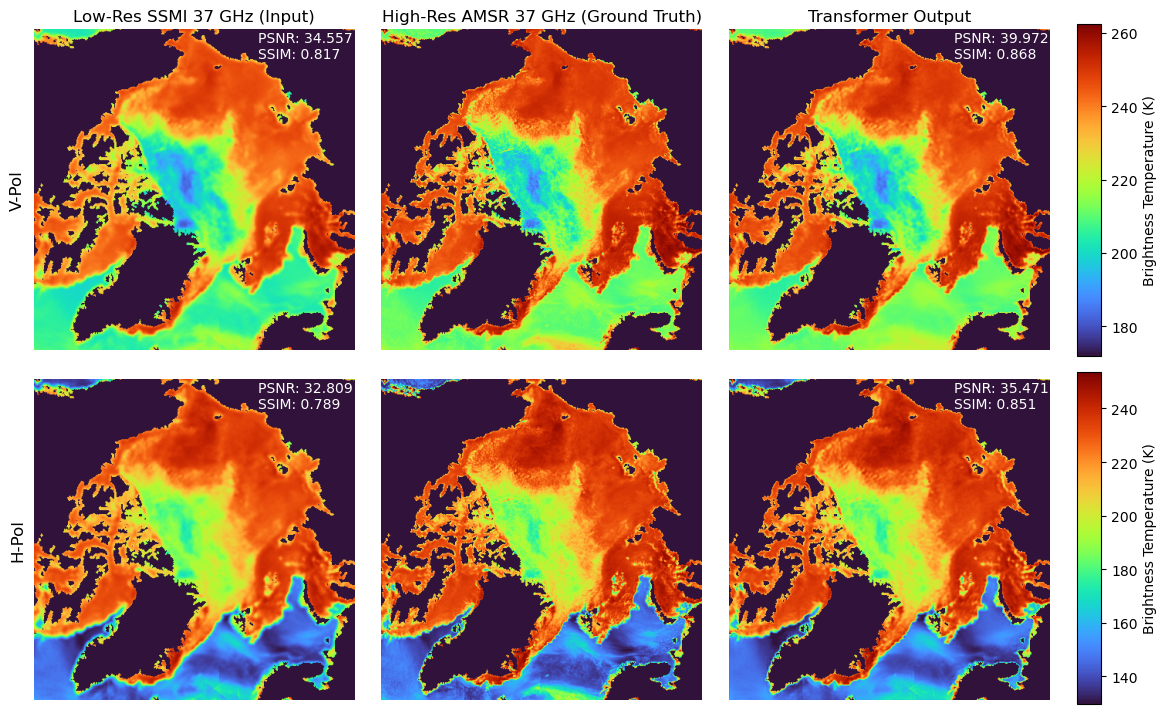

In [11]:
model_pth = "trained_models/ELAN_light1_24h_batchsize8_samplesall_normalized.pth"
plot_single_sample(model_pth,
                test_paths=test_paths,
                test_dataset=test_dataset,
                denormalize = True,
                sample_idx=12);

2020-01-06 12:00:00


/tmp/ipykernel_681681/638802844.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device("cpu")))


Model loaded... 
torch.Size([1, 2, 416, 416])
torch.Size([1, 2, 416, 416])
2025-05-14 15:25:32,184 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fc456e89b80>
2025-05-14 15:25:32,184 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fc456e89b80>
2025-05-14 15:25:32,190 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fc4570e3260>
2025-05-14 15:25:32,190 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fc4570e3260>


/tmp/ipykernel_681681/638802844.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


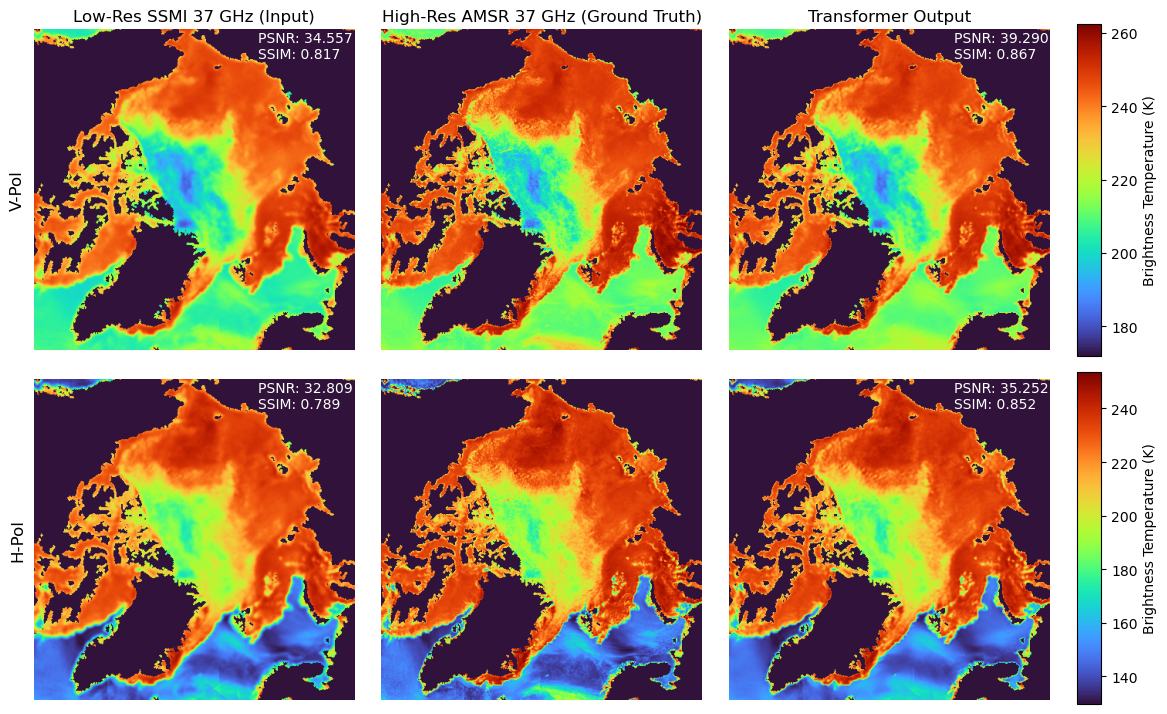

In [13]:
model_pth = "trained_models/SwinIR_24h_batchsize8_samplesall_normalized.pth"
plot_single_sample(model_pth,
                test_paths=test_paths,
                test_dataset=test_dataset,
                denormalize = True,
                sample_idx=12);

In [8]:
def plot_attention_map(model_pth, test_paths, test_dataset, sample_idx, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Plot the final attention map from a Transformer-based model for a single test sample.
    """

    # Extract timestamp from filename
    time = test_paths[sample_idx].split("_")[-1].replace(".nc", "")
    dt = datetime.strptime(str(time), "%Y%m%d%H")
    timestamp_str = dt.strftime("%Y-%m-%d %H:00")
    print(f"Timestamp: {timestamp_str}")

    # Load model
    model = ELAN()
    model.load_state_dict(torch.load(model_pth, map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded...")

    # Get input sample
    low_res, _ = test_dataset[sample_idx]
    low_res_tensor = low_res.unsqueeze(0).to(device)

    # Inference with attention
    with torch.no_grad():
        _, attention_map = model(low_res_tensor, return_attention=True)

    attn_map_tensor = attention_map[0]  # extract first tensor if it's a list
    attn_map_np = attn_map_tensor.squeeze().cpu().numpy()

    # Plot attention map
    plt.figure(figsize=(6, 5))
    im = plt.imshow(attn_map_np, cmap="viridis")
    plt.title(f"Final Attention Map\n{timestamp_str}")
    plt.colorbar(im, label="Attention Weight")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [9]:
    # Extract timestamp from filename
sample_idx = 0
device="cuda" if torch.cuda.is_available() else "cpu"

time = test_paths[sample_idx].split("_")[-1].replace(".nc", "")
dt = datetime.strptime(str(time), "%Y%m%d%H")
timestamp_str = dt.strftime("%Y-%m-%d %H:00")
print(f"Timestamp: {timestamp_str}")

# Load model
model = ELAN()
model.load_state_dict(torch.load(model_pth, map_location=device))
model.to(device)
model.eval()
print("Model loaded...")

# Get input sample
low_res, _ = test_dataset[sample_idx]
low_res_tensor = low_res.unsqueeze(0).to(device)

# Inference with attention
with torch.no_grad():
        _, attention_map = model(low_res_tensor, return_attention=True)


Timestamp: 2020-01-26 12:00
Model loaded...


/tmp/ipykernel_3708183/657312640.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=device))


In [10]:
attn_map_tensor = attention_map[0]  # extract first tensor if it's a list
attn_map_np = attn_map_tensor
print(attn_map_np.shape)

torch.Size([43264, 4, 4])


Timestamp: 2020-04-29 12:00
Model loaded...


/tmp/ipykernel_3708183/1254142643.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=device))


2025-05-09 11:08:46,246 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f023998eab0>
2025-05-09 11:08:46,246 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f023998eab0>


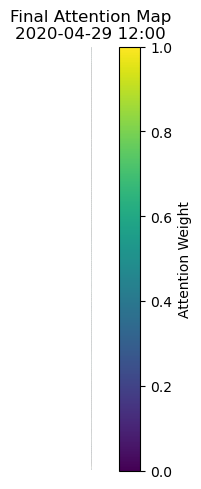

In [11]:
plot_attention_map(model_pth,
                test_paths=test_paths,
                test_dataset=test_dataset,
                sample_idx=100);